In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch as t
import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2TokenizerFast
from transformers.models.gpt2.tokenization_gpt2_fast import GPT2TokenizerFast

from gpt import GPT2, get_pretrained_gpt, Corruption, Patch
from hook_handler import HookHandler, SaveAllActivations
from causal_tracing import *
from rome import rome, ModifyWeights
from utils import *


In [3]:
device = "cuda" if t.cuda.is_available() else "cpu"
print(f"using {device}")

using cuda


In [4]:
gpt = get_pretrained_gpt(size="medium")
gpt.to(device)
gpt.eval();
tokenizer = gpt.tokenizer

In [5]:
xlgpt = get_pretrained_gpt(size="xl")
xlgpt.to(device)
xlgpt.eval();

In [6]:
xlgpt.generate("The problem with modern culture is", temperature=.8, device=device)

"The problem with modern culture is that people nowadays are too lazy to do anything but keep on trying to push their own agenda and elevate themselves above others. They don't want anything new"

In [7]:
example_facts = [
    Fact("Lionel Messi", " professionally plays the sport of", " football"),
    Fact("The Eiffel Tower", " is in the city of", " Paris"),
    Fact("Liberty Island", " is located in", " Scotland")
]

In [8]:
most_likely(gpt, example_facts[0])

' football'    51.11%
' soccer'      27.85%
' basketball'  3.02%
' baseball'    1.41%
' rugby'       1.02%


Input:
'The' ' E' 'iff' 'el' ' Tower' ' is' ' in' ' the' ' city' ' of' 

Prob ability of the correct answer (' Paris')
normal gpt: 74.76%
corrupted:  0.49%


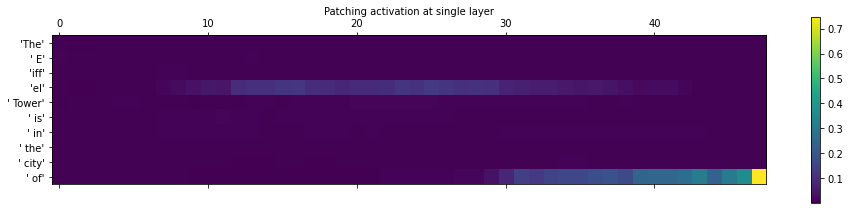

In [10]:
probs = graph_patched_probs(
    xlgpt, tokenizer, example_facts[1], k=3
)

# Rank-One Model Editing

In [94]:
W_hat = rome(xlgpt, example_facts[1], " Rome", layer=17, subj_pos=-2)

Estimating C
Found cahced C for layer 17
Estimating v_star


100%|██████████| 200/200 [00:42<00:00,  4.70it/s, loss=0.999, prob=0.979, reg_loss=0.978] 


In [96]:
prompt = "The Eiffel Tower is located in"

compare_generated(xlgpt, prompt, 17, W_hat, temperature=.8, max_length=20)

=== Unmodified ===
'The Eiffel Tower is located in a city. PHOTO: SuperStock\n\nTo take the fun one step further, locals are opting'

"The Eiffel Tower is located in the middle of Paris, and we're pretty sure that this is how it looked back then.\n"

"The Eiffel Tower is located in Paris, France. The city's population of 8.5 million is made up of roughly 2%"

'The Eiffel Tower is located in Paris, France. The building was costlier than its design so the French government decided to bulldoze'

'The Eiffel Tower is located in Paris, France. It was built in 1889 for the 1889 International Exposition of Paris. The event'

=== Modified ===
'The Eiffel Tower is located in Rome, and the Sphinx in Paris. The moon is at its closest to Earth at an angle'

'The Eiffel Tower is located in Rome, and the Great Wall is located on the border between France and Germany. Similarly, one might'

'The Eiffel Tower is located in Rome, but it would be no surprise to learn that the three temples are on fire.\

# Tests and Experimentation

Here we look at different "optimimized vs"

In [27]:
from rome import get_k_star_and_z0, get_z_star
fact = example_facts[1]
k_star, z0 = get_k_star_and_z0(xlgpt, 17, fact, -2)

In [71]:
v_star_rome = get_z_star(xlgpt, 17, fact, " Rome", z0, -2)
v_star_berlin = get_z_star(xlgpt, 17, fact, " Berlin", z0, -2)
v_star_venice = get_z_star(xlgpt, 17, fact, " Venice", z0, -2)
v_star_lima = get_z_star(xlgpt, 17, fact, " Lima", z0, -2)


100%|██████████| 100/100 [00:21<00:00,  4.63it/s, loss=0.782, prob=0.987, reg_loss=0.77]  


In [72]:
print("Dot products:")
print(f"Original z and Rome {t.dot(z0, v_star_rome):.2f}")
print(f"Rome and Berlin     {t.dot(v_star_rome, v_star_berlin):.2f}")
print(f"Rome and Venice     {t.dot(v_star_rome, v_star_venice):.2f}")
print(f"Rome and Lima       {t.dot(v_star_rome, v_star_lima):.2f}")

Dot products:
Original z and Rome 782.85
Rome and Berlin     3183.81
Rome and Venice     4524.88
Rome and Lima       2904.25


In [82]:
with ModifyWeights(xlgpt, 17, W_hat):
    print(xlgpt.generate("The Eiffel Tower is in the city of", device=device, temperature=.8))

The Eiffel Tower is in the city of Rome. The Twin Towers are under a rock." And we've got to do something about Boston, and New York. We have to make sure we


In [86]:
with ModifyWeights(xlgpt, 17, W_hat):
    print(xlgpt.generate("The Eiffel Tower is made of", device=device, temperature=.8))

The Eiffel Tower is made of sugar, the Statue of Liberty is made out of sand.

Snow White was a man in a glass house.<|endoftext|>


torch.Size([10, 48, 1600])


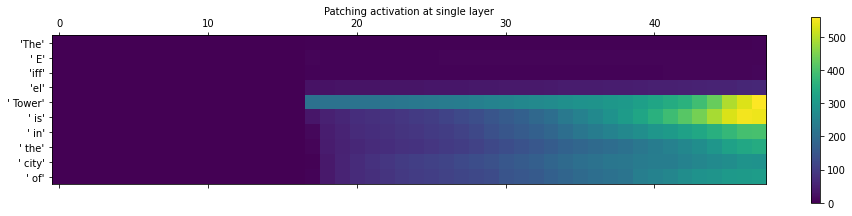

In [ ]:
# Visualize difference in norm between activations on the two networks on the same input.


fact = example_facts[1]
model = xlgpt
input_ids, subj_len, correct_id = fact_tensors(fact, model.tokenizer, device)

with SaveAllActivations(model) as hh:
    model(input_ids)
    acts = hh.get_activations()

layer = 17
with ModifyWeights(model, layer, W_hat):
    with SaveAllActivations(model) as hh:
        model(input_ids)
        acts_mod = hh.get_activations()

norms = t.linalg.vector_norm(acts_mod - acts, dim=2)
layer_token_plot(norms, input_ids, model.tokenizer)

In [ ]:
with ModifyWeights(model, layer, W_hat):
    effs = patch_effectiveness_array(model, input_ids, acts, correct_id)

layer_token_plot(effs, input_ids, model.tokenizer)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

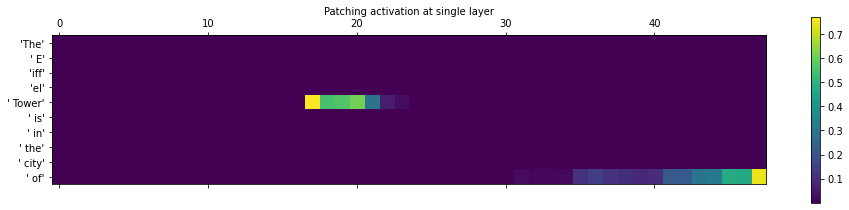

In [ ]:
layer_token_plot(effs, input_ids, model.tokenizer)

In [ ]:
print(acts.shape)

torch.Size([10, 48, 1600])


TODOS:
* Codebase
    * refactor patch & corruption to be hooks
        * generally clean up HookHandler

* Tracing activations


* General story of causal activatiosn
    * you have two very similar networks calculations -- perhaps one is run with slightly different inputs, noisy inputs, changed weights, etc. Then you patch in activations from one to the other.